This notebook deals with the contents of Section 5.3 of the book.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load and inspect data

In [2]:
df = pd.read_csv("data/data-attendance-3.txt")
print(len(df))
print(df.dtypes)
df.head(5)

2396
PersonID     int64
A            int64
Score        int64
Weather     object
Y            int64
dtype: object


,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [3]:
pd.crosstab(df["Weather"], df["Y"])

Y,0,1
Weather,,
A,306,953
B,230,500
C,138,269


In [4]:
# exercise (3)
pd.crosstab(df["A"], df["Y"])

Y,0,1
A,,
0,288,994
1,386,728


# Run Stan

In [5]:
model = CmdStanModel(stan_file="model/model5-5.stan")
print(model)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap05/model/model5-5


CmdStanModel: name=model5-5
	 stan_file=/workdir/chap05/model/model5-5.stan
	 exe_file=/workdir/chap05/model/model5-5
	 compiler_optons=stanc_options=None, cpp_options=None


In [6]:
def weather_to_float(weather):
    if weather == 'A':
        return 0.0
    elif weather =='B':
        return 0.2
    elif weather == 'C':
        return 1.0

In [7]:
data = {
    "I" : len(df),
    "A" : df["A"].values,
    "Score" : df["Score"].values/200,
    "W" : np.vectorize(weather_to_float)(df["Weather"].values),
    "Y" : df["Y"].values
}

In [8]:
fit = model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


# Inspect the result

In [9]:
print(type(fit))
print(fit)

<class 'cmdstanpy.stanfit.CmdStanMCMC'>
CmdStanMCMC: model=model5-5 chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmp735i58h9/model5-5-202009220530-1-y_9lw2_a.csv
	/tmp/tmp735i58h9/model5-5-202009220530-2-10lok0ov.csv
	/tmp/tmp735i58h9/model5-5-202009220530-3-z_6brgdx.csv
	/tmp/tmp735i58h9/model5-5-202009220530-4-11n7dctw.csv
 output_files:
	/tmp/tmp735i58h9/model5-5-202009220530-1-y_9lw2_a-stdout.txt
	/tmp/tmp735i58h9/model5-5-202009220530-2-10lok0ov-stdout.txt
	/tmp/tmp735i58h9/model5-5-202009220530-3-z_6brgdx-stdout.txt
	/tmp/tmp735i58h9/model5-5-202009220530-4-11n7dctw-stdout.txt


In [10]:
print(fit.num_draws)
print(fit.draws().shape)

1000
(1000, 4, 2407)


In [11]:
fit.stan_variables()

{'b': array([[ 0.0597895, -0.681811 ,  2.27744  , -0.567132 ],
        [-0.105071 , -0.762969 ,  2.57661  , -0.574847 ],
        [ 0.250873 , -0.612446 ,  1.69933  , -0.13637  ],
        ...,
        [ 0.334344 , -0.464366 ,  1.64419  , -0.439668 ],
        [ 0.0514889, -0.638614 ,  2.08828  , -0.57938  ],
        [ 0.111857 , -0.618817 ,  2.27868  , -0.629433 ]]),
 'q': array([[0.675262, 0.699624, 0.569148, ..., 0.623707, 0.48455 , 0.48455 ],
        [0.661255, 0.686511, 0.552064, ..., 0.60046 , 0.458232, 0.458232],
        [0.692082, 0.697863, 0.668359, ..., 0.617653, 0.584974, 0.584974],
        ...,
        [0.692888, 0.711276, 0.61347 , ..., 0.664598, 0.560745, 0.560745],
        [0.658377, 0.683942, 0.547993, ..., 0.609824, 0.466847, 0.466847],
        [0.683978, 0.710539, 0.566742, ..., 0.650443, 0.497889, 0.497889]])}

In [12]:
fit_summary = fit.summary()
fit_summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1383.06,0.034133,1.40072,-1385.87,-1382.73,-1381.42,1684.01,36.5786,1.00136
b[1],0.16,0.004900,0.22000,-0.20,0.16,0.53,2121.00,46.0000,1.00000
b[2],-0.62,0.001700,0.09300,-0.77,-0.62,-0.47,2813.00,61.0000,1.00000
b[3],2.00,0.007600,0.35000,1.40,2.00,2.50,2185.00,47.0000,1.00000
b[4],-0.46,0.002300,0.12000,-0.66,-0.46,-0.26,2947.00,64.0000,1.00000
...,...,...,...,...,...,...,...,...,...
q[2392],0.61,0.000340,0.01800,0.58,0.61,0.63,2935.00,64.0000,1.00000
q[2393],0.63,0.000360,0.01900,0.59,0.63,0.66,2815.00,61.0000,1.00000
q[2394],0.63,0.000360,0.01900,0.59,0.63,0.66,2815.00,61.0000,1.00000


In [13]:
# Check the convergence
fit_summary[fit_summary["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


In [14]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmp735i58h9/model5-5-202009220530-1-y_9lw2_a.csv, /tmp/tmp735i58h9/model5-5-202009220530-2-10lok0ov.csv, /tmp/tmp735i58h9/model5-5-202009220530-3-z_6brgdx.csv, /tmp/tmp735i58h9/model5-5-202009220530-4-11n7dctw.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Processing csv files: /tmp/tmp735i58h9/model5-5-202009220530-1-y_9lw2_a.csv, /tmp/tmp735i58h9/model5-5-202009220530-2-10lok0ov.csv, /tmp/tmp735i58h9/model5-5-202009220530-3-z_6brgdx.csv, /tmp/tmp735i58h9/model5-5-202009220530-4-11n7dctw.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


# Plot the result

In [15]:
q_percentiles = np.percentile(fit.stan_variable("q"), [10.0, 50.0, 90.0], axis=0)
q_percentiles.shape

(3, 2396)

Text(0, 0.5, 'q')

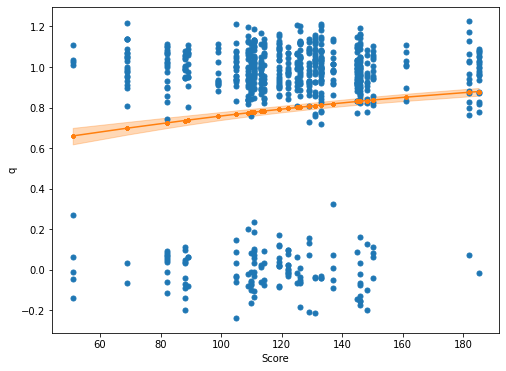

In [16]:
# Plot score vs q (for weather = 'A' and 'A' = 0 only)

df_tmp = df.sort_values(by=["Score"])[["Weather", "A"]]
idx = df_tmp[(df_tmp["Weather"] == 'A') & (df_tmp['A'] == 0)].index.values

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

ax.plot(df["Score"][idx], df["Y"][idx] + 0.1*np.random.randn(len(idx)), 'o', markersize=5, color="C0")
ax.plot(df["Score"][idx], q_percentiles[1][idx], '.-', color="C1")
ax.fill_between(df["Score"][idx], q_percentiles[0][idx], q_percentiles[2][idx], alpha=0.3, color="C1")
ax.set_xlabel("Score")
ax.set_ylabel("q")

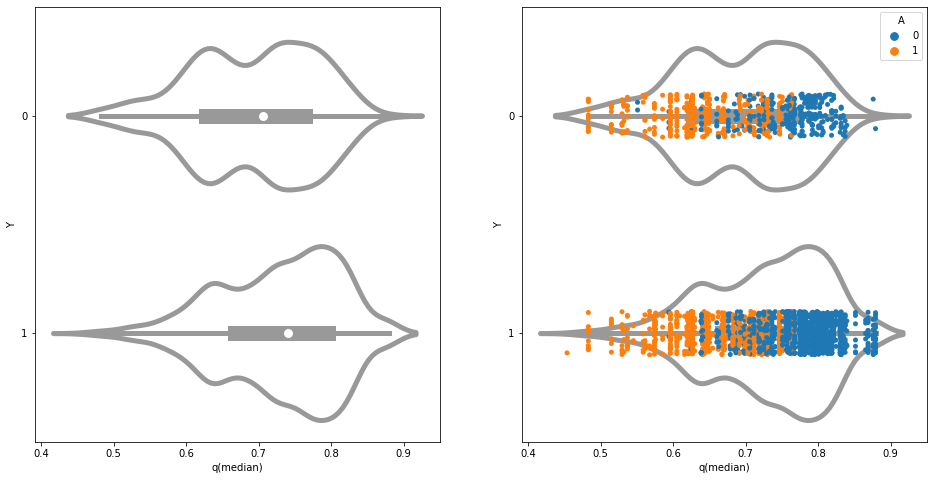

In [17]:
# prob vs. observation

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax = axes[0]
sns.violinplot(x=q_percentiles[1], y=df["Y"], color='white', linewidth=5, orient='h', ax=ax)
ax.set_xlabel("q(median)")

ax = axes[1]
sns.violinplot(x=q_percentiles[1], y=df["Y"], color='white', linewidth=5, orient='h', ax=ax)
sns.stripplot(x=q_percentiles[1], y=df["Y"], hue=df["A"], orient='h', ax=ax)
ax.set_xlabel("q(median)")

plt.show()

ROC AUC Score : 0.6169931278583665


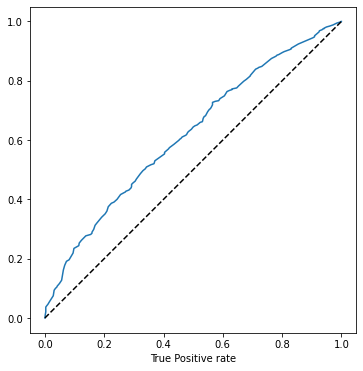

In [18]:
# ROC curve : 

print("ROC AUC Score :", roc_auc_score(df["Y"].values, q_percentiles[1]))

fpr, tpr, thresholds = roc_curve(df["Y"].values, q_percentiles[1])
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], 'k--')
ax.set_aspect("equal")
ax.set_xlabel("False Positive rate")
ax.set_xlabel("True Positive rate")
plt.show()